## Addressing point 1 - we try and simulate the effect of the Mx selection effect on the Mx/Mc relation.

In [1]:
#Imports
import os

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9 as cosmo

%matplotlib inline

In [2]:
#Set important parameters
np.random.seed(0)

LxMx_slope = 1.34 #(Mantz 2010 eqn 5 and Table 7)
LxMx_norm = 0.80 #(Mantz 2010 eqn 5 and Table 7)

In [3]:
#Set up covariance matrix
Lx_scatter = np.log10(1.3) #np.log10(1.3) #** 2
Mx_scatter = np.log10(1.1) #np.log10(1.1) #** 2
LxMx_corr = 0.5 #0,0.5,1
LxMx_cov = LxMx_corr * Lx_scatter * Mx_scatter

LxMx_cov_mat = np.array([[Lx_scatter**2,LxMx_cov],
                         [LxMx_cov,Mx_scatter**2]])

Mc_scatter = np.log10(1.3) #np.log10(1.3) #** 2

In [4]:
#Set up covariance matrix - NOW TRY SETTTING IT UP IN NATURAL LOG SPACE, THEN COVERTING 
#AT THE END INTO LOG10 SPACE - CHECK I GET THE SAME RESULT AS SETTING UP THE COVARIANCE
#MATRIX DIRECTLY IN LOG10 SPACE
Lx_scatter_ln = 0.26236426446749106#0.3 #np.log10(1.3) #np.log10(1.3) #** 2
Mx_scatter_ln = 0.09531017980432493#0.1 #np.log10(1.1) #np.log10(1.1) #** 2
#LxMx_corr = 0#np.log10(1.5) #np.log10([1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,1000,100000,10000000,1e15,1e100])
LxMx_cov = LxMx_corr * Lx_scatter_ln * Mx_scatter_ln

LxMx_cov_mat_ln = np.array([[Lx_scatter_ln**2,LxMx_cov],
                         [LxMx_cov,Mx_scatter_ln**2]])

#scale to base 10 log
LxMx_cov_mat_log10_initially_ln = LxMx_cov_mat_ln/np.log(10)**2

print(LxMx_cov_mat_log10_initially_ln)
print(LxMx_cov_mat)

#Mc_scatter = np.log10(1.3) #np.log10(1.3) #** 2

[[0.01298309 0.00235821]
 [0.00235821 0.00171335]]
[[0.01298309 0.00235821]
 [0.00235821 0.00171335]]


I've now set up the covariance matrix, but I'm not sure I've done it right. What complicates things is that we are working with our masses and luminosities in log space. The next two code blocks are to try and understand things further! I do now think we h

In [5]:
def cov2corr(cov, return_std=False):
    """
    convert covariance matrix to correlation matrix (TAKEN FROM https://www.statsmodels.org/stable/_modules/statsmodels/stats/moment_helpers.html#cov2corr)

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires that
    division is defined elementwise. np.ma.array and np.matrix are allowed.
    """
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

In [6]:
corr_mat = cov2corr(LxMx_cov_mat)
print(LxMx_cov_mat)
print(corr_mat)

# LxMx_corr = 0.5#np.log10(1) #np.log10([1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,1000,100000,10000000,1e15,1e100])
# LxMx_cov = LxMx_corr * Lx_scatter * Mx_scatter
# LxMx_cov_mat = np.array([[Lx_scatter**2,LxMx_cov],
#                          [LxMx_cov,Mx_scatter**2]])
# corr_mat = cov2corr(LxMx_cov_mat)
# print(LxMx_cov_mat)
# print(corr_mat)

[[0.01298309 0.00235821]
 [0.00235821 0.00171335]]
[[1.  0.5]
 [0.5 1. ]]


In [7]:
########
#read in M,z pairs (these are sampled from a mass function -
#BM gave me this file)
########
df = pd.read_csv('checs50Mz_fromBM.dat',delim_whitespace = True)
#df['log10M500']
#df['z']
#df['log10Ez']

#Make the df four times as large simply by copying the first half into the second half
#so there are more points in the mass range of interest
df = df.append(df)
df = df.append(df)

df['M500'] = 10 ** df['log10M500']
df['Ez'] = 10 ** df['log10Ez']

Text(0.5, 1.0, 'Replicate Mantz 2010 Fig 3 (no scatter added yet, just scaling relation)')

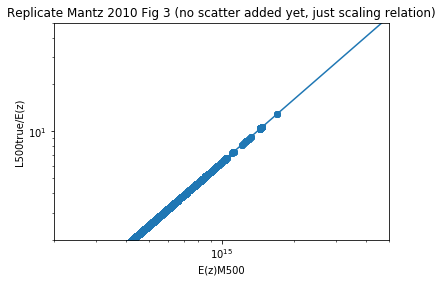

In [8]:
########
#Get Lx and Mx and add to the df (Mantz 2010 eqn 5 and Table 7)
########
#we want to get L500true
df['L500true'] = df['Ez'] * 10 ** ( LxMx_norm + LxMx_slope * np.log10(df['Ez']*df['M500']/10**15) )
df['log10L500true'] = np.log10(df['L500true'])

#Try and replicate Mantz 2010 Figure 3 LHS to check I've done it right
plt.scatter(df['Ez']*df['M500'],df['L500true']/df['Ez'])
plt.plot(np.linspace(1e14,50e14,10), 10 ** ( LxMx_norm + LxMx_slope * np.log10(np.linspace(1e14,50e14,10)/10**15) ))
plt.xlim(2e14,50e14)
plt.ylim(2,50)
plt.xlabel('E(z)M500')
plt.ylabel('L500true/E(z)')
plt.xscale('log')
plt.yscale('log')
plt.title('Replicate Mantz 2010 Fig 3 (no scatter added yet, just scaling relation)')
#plt.savefig('Mantz_relation_no_scatter.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Lx (i.e. scatter added) vs Ltrue')

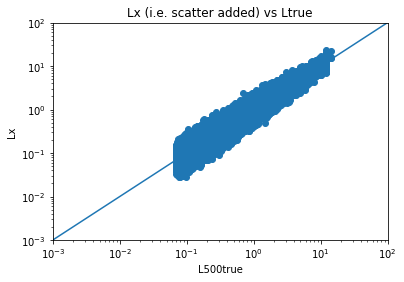

In [9]:
#now sample from a 2D Gaussian with a covariance matrix to describe the
#relation between Lx and Mx
# log10Lx = np.array([])
# log10Mx = np.array([])
# for i in range(len(df)):
#     if i%10000 == 0:
#         print(f'{np.round(i/len(df)*len(df)/4000)}% done')
#         #scipy.stats.multivariate_normal.rvs()
#     random_sample = np.random.multivariate_normal(mean = np.array([df['log10L500true'].iloc[i],df['log10M500'].iloc[i]]),
#                                                   cov = LxMx_cov_mat)
#     log10Lx = np.append(log10Lx, random_sample[0])
#     log10Mx = np.append(log10Mx, random_sample[1])
    
# df['log10Lx'] = log10Lx
# df['log10Mx'] = log10Mx

#This is quicker than the above for loop
samples = np.array(list(map(np.random.multivariate_normal,
        np.array([df['log10L500true'],df['log10M500']]).transpose(),
        [LxMx_cov_mat for i in range(len(df))])))
df['log10Lx'] = samples[:,0]
df['log10Mx'] = samples[:,1]



df['Lx'] = 10 ** df['log10Lx']
df['Mx'] = 10 ** df['log10Mx']

#plot Ltrue vs Lx just to see scatter and that it's worked as expected
plt.scatter(df['L500true'],df['Lx'])
plt.xlim([10**-3,10**2])
plt.ylim([10**-3,10**2])
plt.plot([10**-3,10**2],[10**-3,10**2])
plt.xlabel('L500true')
plt.ylabel('Lx')
plt.xscale('log')
plt.yscale('log')
plt.title('Lx (i.e. scatter added) vs Ltrue')
#plt.savefig(f'{plots_dir}/Lx_vs_Ltrue.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Mx (i.e. scatter added) vs M500 (true)')

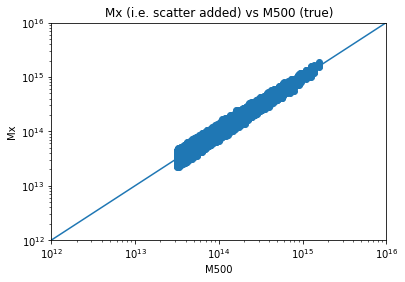

In [10]:
#plot Ltrue vs Lx just to see scatter and that it's worked as expected
plt.scatter(df['M500'],df['Mx'])
plt.xlim([10**12,10**16])
plt.ylim([10**12,10**16])
plt.plot([10**12,10**16],[10**12,10**16])
plt.xlabel('M500')
plt.ylabel('Mx')
plt.xscale('log')
plt.yscale('log')
plt.title('Mx (i.e. scatter added) vs M500 (true)')
#plt.savefig(f'{plots_dir}/Mx_vs_Mtrue.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Replicate Mantz 2010 Fig 3 (with scatter on Lx)')

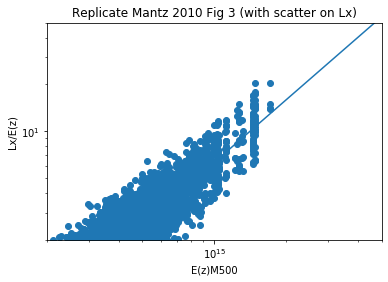

In [11]:
#Try and replicate Mantz 2010 Figure 3 LHS to check I've done it right WITH SCATTER ON LX
plt.scatter(df['Ez']*df['M500'],df['Lx']/df['Ez'])
plt.plot(np.linspace(1e14,50e14,10), 10 ** ( LxMx_norm + LxMx_slope * np.log10(np.linspace(1e14,50e14,10)/10**15) ))
plt.xlim(2e14,50e14)
plt.ylim(2,50)
plt.xlabel('E(z)M500')
plt.ylabel('Lx/E(z)')
plt.xscale('log')
plt.yscale('log')
plt.title('Replicate Mantz 2010 Fig 3 (with scatter on Lx)')
#plt.savefig(f'{plots_dir}/Mantz_relation_with_scatter_on_Lx.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Replicate Mantz 2010 Fig 3 (with scatter on Lx - ZOOMED OUT)')

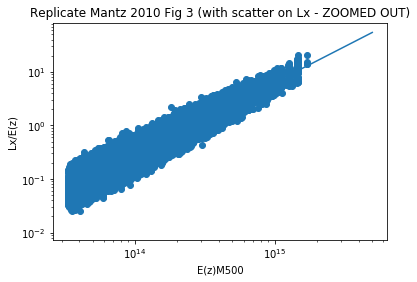

In [12]:
plt.scatter(df['Ez']*df['M500'],df['Lx']/df['Ez'])
plt.plot(np.linspace(1e14,50e14,10), 10 ** ( LxMx_norm + LxMx_slope * np.log10(np.linspace(1e14,50e14,10)/10**15) ))
#plt.xlim(2e14,50e14)
#plt.ylim(2,50)
plt.xlabel('E(z)M500')
plt.ylabel('Lx/E(z)')
plt.xscale('log')
plt.yscale('log')
plt.title('Replicate Mantz 2010 Fig 3 (with scatter on Lx - ZOOMED OUT)')
#plt.savefig(f'{plots_dir}/Mantz_relation_with_scatter_on_Lx_ZOOMED_OUT.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Replicate Mantz 2010 Fig 3 (with scatter on Lx and Mx)')

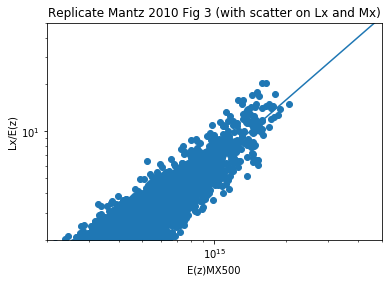

In [13]:
#Try and replicate Mantz 2010 Figure 3 LHS to check I've done it right WITH SCATTER ON LX AND MX
plt.scatter(df['Ez']*df['Mx'],df['Lx']/df['Ez'])
plt.plot(np.linspace(1e14,50e14,10), 10 ** ( LxMx_norm + LxMx_slope * np.log10(np.linspace(1e14,50e14,10)/10**15) ))
plt.xlim(2e14,50e14)
plt.ylim(2,50)
plt.xlabel('E(z)MX500')
plt.ylabel('Lx/E(z)')
plt.xscale('log')
plt.yscale('log')
plt.title('Replicate Mantz 2010 Fig 3 (with scatter on Lx and Mx)')
#plt.savefig(f'{plots_dir}/Mantz_relation_with_scatter_on_Lx_and_Mx.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Replicate Mantz 2010 Fig 3 (with scatter on Lx and Mx - ZOOMED OUT)')

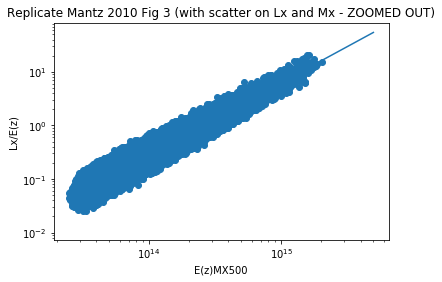

In [14]:
plt.scatter(df['Ez']*df['Mx'],df['Lx']/df['Ez'])
plt.plot(np.linspace(1e14,50e14,10), 10 ** ( LxMx_norm + LxMx_slope * np.log10(np.linspace(1e14,50e14,10)/10**15) ))
#plt.xlim(2e14,50e14)
#plt.ylim(2,50)
plt.xlabel('E(z)MX500')
plt.ylabel('Lx/E(z)')
plt.xscale('log')
plt.yscale('log')
plt.title('Replicate Mantz 2010 Fig 3 (with scatter on Lx and Mx - ZOOMED OUT)')
#plt.savefig(f'{plots_dir}/Mantz_relation_with_scatter_on_Lx_and_Mx_ZOOMED_OUT.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'M vs z')

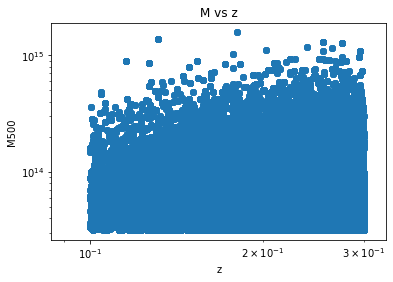

In [15]:
#Plot M vs z
plt.scatter(df['z'],df['M500'])
plt.xlabel('z')
plt.ylabel('M500')
plt.xscale('log')
plt.yscale('log')
plt.title('M vs z')
#plt.savefig(f'{plots_dir}/M_vs_z.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Mx vs z')

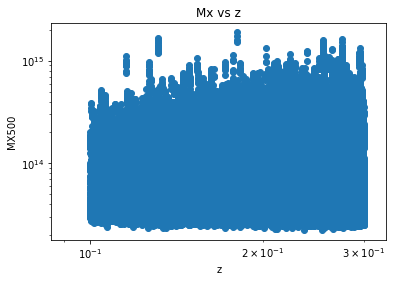

In [16]:
#Plot Mx vs z
plt.scatter(df['z'],df['Mx'])
plt.xlabel('z')
plt.ylabel('MX500')
plt.xscale('log')
plt.yscale('log')
plt.title('Mx vs z')
#plt.savefig(f'{plots_dir}/Mx_vs_z.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Lx vs z')

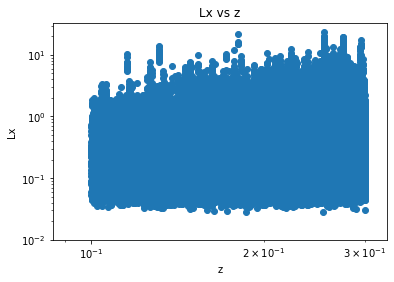

In [17]:
#Plot Lx vs z
plt.scatter(df['z'],df['Lx'])
plt.xlabel('z')
plt.ylabel('Lx')
plt.xscale('log')
plt.yscale('log')
plt.title('Lx vs z')
#plt.savefig(f'{plots_dir}/Lx_vs_z.png')
#plt.show()
#plt.clf()
#plt.cla()

In [18]:
########
#Add flux to df (flux = L / 4* pi * r^2)
########
df['LumDistMpc'] = cosmo.luminosity_distance(df['z'])
df['LumDistCm'] = df['LumDistMpc'] * 3.086e24

df['Fluxergcms'] = df['Lx'] * 1e44 / ( 4 * np.pi * df['LumDistCm']**2 )

In [19]:
np.log10(df['Fluxergcms']).max()

-10.529708748486923

Text(0.5, 1.0, 'M500 vs flux')

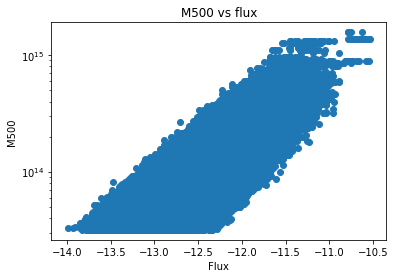

In [20]:
#Plot M vs flux
plt.scatter(np.log10(df['Fluxergcms']),df['M500'])
plt.xlabel('Flux')
plt.ylabel('M500')
#plt.xscale('log')
plt.yscale('log')
plt.title('M500 vs flux')
#plt.savefig(f'{plots_dir}/M_vs_flux.png')
#plt.show()
#plt.clf()
#plt.cla()

Text(0.5, 1.0, 'Mx vs flux')

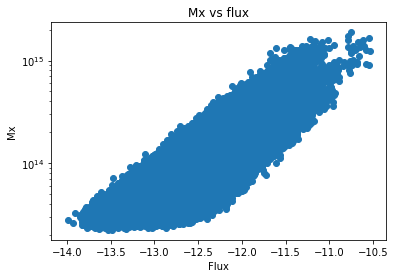

In [21]:
#Plot Mx vs flux
plt.scatter(np.log10(df['Fluxergcms']),df['Mx'])
plt.xlabel('Flux')
plt.ylabel('Mx')
#plt.xscale('log')
plt.yscale('log')
plt.title('Mx vs flux')
#plt.savefig(f'{plots_dir}/Mx_vs_flux.png')
#plt.show()
#plt.clf()
#plt.cla()

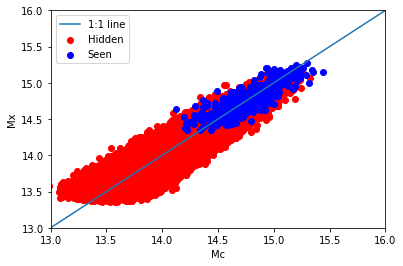

In [22]:
########
#assign a Mc assuming a 30% scatter and add to df
########
df['log10Mc'] = np.random.normal(loc = df['log10M500'], scale = Mc_scatter)
df['Mc'] = 10**df['log10Mc']

########
#plot Mx vs Mc with and without selection effect
########
#Apply flux selection effect
selection_effect_mask =  df['Fluxergcms'] > 5e-12

plt.scatter(df['log10Mc'][np.invert(selection_effect_mask)], df['log10Mx'][np.invert(selection_effect_mask)], c = 'r', label = 'Hidden')
plt.scatter(df['log10Mc'][selection_effect_mask], df['log10Mx'][selection_effect_mask], c = 'b', label = 'Seen')
plt.plot([13,16], [13,16], label = '1:1 line')
plt.xlim([13,16])
plt.ylim([13,16])
plt.xlabel('Mc')
plt.ylabel('Mx')
plt.legend()
#plt.savefig(f'{plots_dir}/Mx_VS_Mc_FINAL_PLOT.png')
#plt.show()
#plt.clf()
#plt.cla()

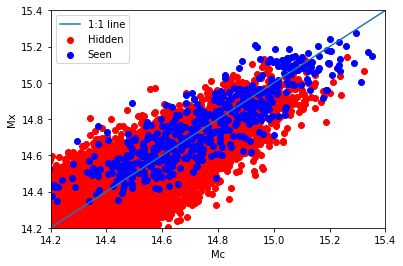

In [23]:
plt.scatter(df['log10Mc'][np.invert(selection_effect_mask)], df['log10Mx'][np.invert(selection_effect_mask)], c = 'r', label = 'Hidden')
plt.scatter(df['log10Mc'][selection_effect_mask], df['log10Mx'][selection_effect_mask], c = 'b', label = 'Seen')
plt.plot([14.2,15.4], [14.2,15.4], label = '1:1 line')
plt.xlim([14.2,15.4])
plt.ylim([14.2,15.4])
plt.xlabel('Mc')
plt.ylabel('Mx')
plt.legend()
plt.savefig(f'Mx_VS_Mc_FINAL_PLOT_corr{LxMx_corr}.png')

Now  check the size of the effect by taking the median Mx/Mc in bins of Mc to compare 
with the values in the plot in the Mx/Mc paper with 44 points - we do this by plotting a line connecting these medians on the Mx/Mc plot. (We take medians to avoid taking the means of the Mx/Mc ratios). ACTUALLY I THINK WE WANT TO FIND THE MEDIAN MX IN A GIVEN MC BIN? THIS IS WHAT I'VE DONE - CHECK OK WITH BM

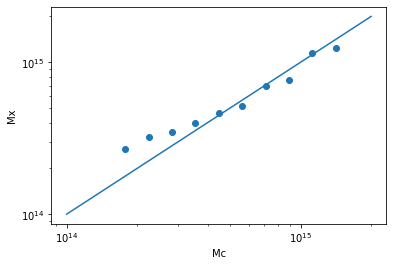

In [24]:
bin_width = 0.1
Mc_min = 14.2
Mc_max = 15.2
Mc_vals = np.linspace(Mc_min,Mc_max,int((Mc_max-Mc_min)/bin_width)+1)
Mc_vals_midpoints = Mc_vals[:-1]+bin_width/2
Mx_medians_for_Mc_bin = []
for Mc_val in Mc_vals[:-1]:
    Mc_mask = np.logical_and(df['Mc']>10**Mc_val,df['Mc']<10**(Mc_val+bin_width))
    Mx_medians_for_Mc_bin.append(df['Mx'][np.logical_and(selection_effect_mask,Mc_mask)].median())
    
plt.scatter(10**Mc_vals_midpoints,Mx_medians_for_Mc_bin)
plt.plot([1e14,2e15],[1e14,2e15])
plt.xlabel('Mc')
plt.ylabel('Mx')
plt.xscale('log')
plt.yscale('log')
plt.savefig(f'Mx_VS_Mc_FINAL_PLOT_BINNED_corr{LxMx_corr}.png')

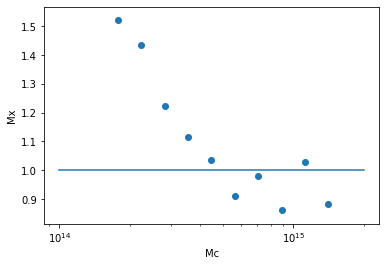

In [25]:
#Also plot Mx/Mc value in each Mc bin
plt.scatter(10**Mc_vals_midpoints,Mx_medians_for_Mc_bin/(10**Mc_vals_midpoints))
plt.plot([1e14,2e15],[1,1])
plt.xlabel('Mc')
plt.ylabel('Mx')
plt.xscale('log')
#plt.yscale('log')
plt.savefig(f'Mx_VS_Mc_FINAL_PLOT_BINNED_1TO1_LINE_corr{LxMx_corr}.png')

In [26]:
#Read in Mx and Mc vals and errors for the 44 points in my Mx/Mc paper and plot the 
#simulated results in bins there (and plot a line joining them)
#obs_df = pd.read_csv('',delim_whitespace=True)


## Checks
Here are some checks and interesting plots to help us understand what we are doing/ what we are doing wrong (!)